In [57]:
%matplotlib inline

import pandas as pd
import numpy as np

import quandl as qd
import configparser as cp

config = cp.ConfigParser()
config.read('/home/zwl/.prop.config')
qd.ApiConfig.api_key = config['quandl'].get('API_KEY')

Collection of notes on quantitative trading strategies

The first section of notes are based on Ernest Chan's Algorithmic Trading book.


# Hypothesis Testing for Backtesting

* p-value based, Critical value = $\sqrt{n} \times \text{DailySharpeRatio}$, given $n$ is the number of days in the backtest. critial values: 1.645, 2.326, 3.091 for p values: 0.05, 0.01, 0.001. See coding example below.
* Simulation based, generate price data and feed to strategy
* Andrew Lo: Generate trades based on original historical price series, constraints: same number of long and short entries as the backtest, with same average holding periods. 



Critical Values are based on normal distributio with 0 mean and unit variance. 

The test statistic is caluclated as, [link](http://artmathonline.com/files/hypothesisteststeps1.pdf), [code](https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa-in-python)

$$ z = \frac{\bar{x} - \mu}{\sigma / \sqrt{n}} = \sqrt{n} \times \frac{\bar{x} - \mu}{\sigma}$$

This can be done with `scipy.stats.ttest_1samp(daily_returns)`.

In [55]:
import statsmodels.stats.weightstats as ssw
import numpy as np
import scipy.stats as ss

In [44]:
ss.norm.ppf(.9)

1.2815515655446004

In [43]:
ss.norm.ppf(.95)

1.6448536269514722

In [45]:
ss.norm.ppf(.99)

2.3263478740408408

In [46]:
ss.norm.ppf(.999)

3.0902323061678132

From critical value to p-value:

In [49]:
ss.norm.cdf(2.5)

0.99379033467422384

In [8]:
rtns = np.random.rand(252) / 10.

In [59]:
cval = np.mean(rtns) / sd * np.sqrt(252)
cval

25.402687920083974

In [60]:
1 - ss.norm.cdf(cval)

0.0

In [62]:
ss.ttest_1samp(rtns, popmean=0)

Ttest_1sampResult(statistic=25.402687920083977, pvalue=2.5044480595647219e-71)

# Mean Reversion

## ADF test

Essentially this is testing whether the **beta coefficient** for 1-day lagged returns in an autoregressive model is **zero**. If the null hypothesis that beta equals zero is rejected, then the time series is **not a random walk**.

In a mean reversion setting, we expect beta to be **negative**

## Hurst Exponent 

H = 0.5 indicates geometric random walk. H < 0.5 indicates mean reversion, H > 0.5 indicates trending series.

## Variance Ratio Test

Statistical test for Hurst exponent, null hypothesis is that the time series is a random walk. Small p-values rejects this hypothesis.

## Half-Life of Mean Reversion

see this [notebook](\../notebooks/git/notebooks/python/time_series.ipynb)

Based on O-U process formula in discrete time scale.

** half-life** $= -\log(2)/\lambda$, implying that $\lambda$ should be **negative** for mean reverting series. 

where $\lambda$ is the beta based on regressing price change versus lagged price: `px_{t} - px_{t-1} ~ px_{t-1} + 1`.

In a strategy, half-life is used as the rolling average window for z-scoring.

In [44]:
import pyhistdata as phd

In [59]:
def daily_fx(ccy):
    fx = phd.load_fx(ccy, source_dir='/home/zwl/data/fx/csv')
    df = fx.between_time('16:00', '16:30')
    return df.resample('B').last()

In [74]:
cad = phd.load_fx('USDCAD', source_dir='/home/zwl/data/fx/csv')

In [46]:
cadx = cad.loc['2007-07-22':'2012-03-28']

In [47]:
cadx = cadx.between_time('07:00', '17:00')

In [70]:
cad_d = cadx.resample('B').last()

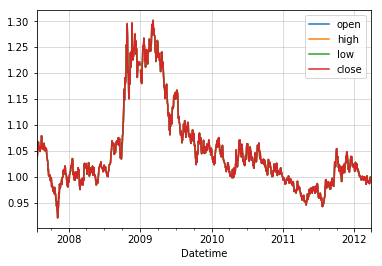

In [71]:
cad_d.plot()

In [51]:
close = cad_d.close
df = pd.DataFrame(dict(chg=close.diff(), lag=close.shift(1)))
df.tail()

,chg,lag
Datetime,,
2012-03-22,0.00741,0.99201
2012-03-23,-0.00144,0.99942
2012-03-26,-0.00740,0.99798
2012-03-27,0.00452,0.99058
2012-03-28,0.00330,0.99510


In [52]:
import statsmodels.formula.api as sm

In [53]:
m = sm.ols('chg ~ lag', data=df.dropna()).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chg   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.399
Date:                Wed, 12 Jul 2017   Prob (F-statistic):             0.0655
Time:                        22:45:18   Log-Likelihood:                 4025.7
No. Observations:                1213   AIC:                            -8047.
Df Residuals:                    1211   BIC:                            -8037.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0061      0.003      1.831      0.067      -0.000       0.013
lag           -0.0059      0.003     -1.844      0.065      -0.012       0.000
==============================================================================
Omnibus:                       98.207   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              377.387
Skew:                           0.298   Prob(JB):                     1.13e-82
Kurtosis:                       5.667   Cond. No.                         26.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# half life
-np.log(2) / m.params[1]

118.45822902103323

## Cointegration

### CADF test

Testing for mean reversion for spread of a pair of securities. When using CADF, the order of variables matters, so need to try different order (dependent vs independent) to find the best p-value order, to obtain the hedge ratio.

### Johansen Test

See `R`'s `urca` and `tseries` package. This test has recently been added to `statsmodels` via its `VECM` model addtion, see [here](https://github.com/statsmodels/statsmodels/blob/09bd0c5cdd0e0da9281cde983653969c0557ce5f/statsmodels/tsa/vector_ar/vecm.py#530)

Johansen test is independent of the order of the price series, it tests all the independent cointegrating relations that exist.

The eigenvalues are the hedge ratios.

see this [notebook](\../notebooks/git/notebooks/python/time_series.ipynb) for more on this topic, including Philipp-Ouliaris (PO) test.

Can use **price, log(price), or ratio** to construct cointegrating pairs for trading. FX is an example of ratio

# FX Cointegration Example

In [75]:
nok = daily_fx('USDNOK')
cad = daily_fx('USDCAD')

In [76]:
df = pd.DataFrame(dict(nok=nok.close, cad=cad.close))

In [82]:
df.dropna(inplace=True)

In [132]:
m = sm.ols('cad ~ nok', data=df).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cad   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 2.289e+04
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        23:22:03   Log-Likelihood:                 4053.2
No. Observations:                2150   AIC:                            -8102.
Df Residuals:                    2148   BIC:                            -8091.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3501      0.005     68.471      0.000       0.340       0.360
nok            0.1167      0.001    151.299      0.000       0.115       0.118
==============================================================================
Omnibus:                      309.136   Durbin-Watson:                   0.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              468.889
Skew:                           1.016   Prob(JB):                    1.52e-102
Kurtosis:                       4.053   Cond. No.                         43.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

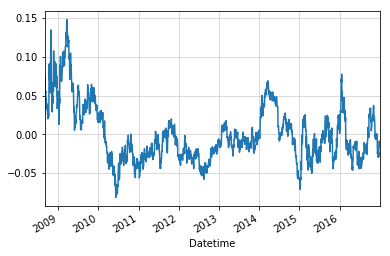

In [133]:
m.resid.plot()

In [136]:
hl = -np.log(2) / m.params[1]
hl

-5.938165499574084

In [88]:
import arch.unitroot as au

/usr/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [92]:
au.ADF(m.resid, )

Test Statistic,-3.621
P-value,0.005
Lags,5


In [96]:
print(au.VarianceRatio(m.resid).summary().as_text())

     Variance-Ratio Test Results     
Test Statistic                 -3.014
P-value                         0.003
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)


In [137]:
n = len(df)
window = 22*6
beta = []
for i in range(n-window):
    d = df.iloc[i:i+window, :]
    m = sm.ols('cad ~ nok - 1', data=d).fit()
    b = m.params[0]
    ind = d.index[-1]
    beta.append((ind, b))

In [138]:
betas = pd.DataFrame.from_records(beta, columns=['date', 'beta'])

In [139]:
betas.set_index('date', inplace=True)

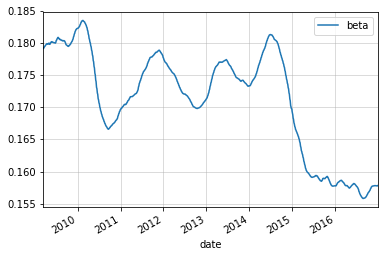

In [140]:
betas.plot()

In [141]:
pred = betas.mul(df.nok, axis='index')

In [142]:
dx = df.assign(pred=pred)

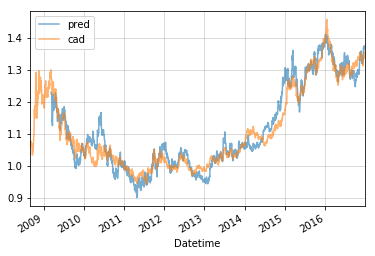

In [143]:
dx[['pred', 'cad']].plot(alpha=.6)

In [146]:
resid = dx.pred - dx.cad

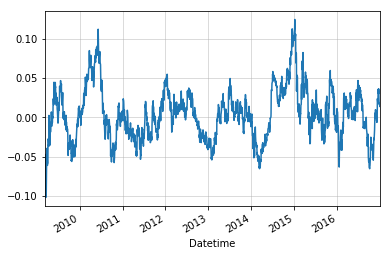

In [148]:
resid.dropna().plot()